<a class="anchor" id="0"></a>
# **Time Series Modeling**


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt   # data visualization
import seaborn as sns             # statistical data visualization
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})


## **Import data**

In [13]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 557.6 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 1.6 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Using cached aiosignal-1.3.1-py3-none-any.whl.metadata (4.0 kB)
  Using cached attrs-23.2.0-py3-none-any.whl.metadata (9.5 kB)
  Using cached frozenlist-1.4.1-cp39-cp39-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached multidict-6.0.5-cp39-cp39-macosx_11_0_arm64.whl.metadata (4.2 kB)
  Using cached yarl-1.9.4-cp39-cp39-macosx_11_0_arm64.whl.metadata (31 kB)
  Using cached async_timeout-4.0.3-py3-none-any.whl.metadata (4.2 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 6.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.4 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.4/630.4 kB 6.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.3/802.3 kB 6.9 MB/s eta 0:0

In [14]:
from darts.datasets import ElectricityDataset

Number of components is larger than 10 (370). Plotting only the first 10 components.You can overwrite this in the using the `plot_all_components` argument in plot()Beware that plotting a large number of components may cause performance issues.


<Axes: xlabel='Unnamed: 0'>

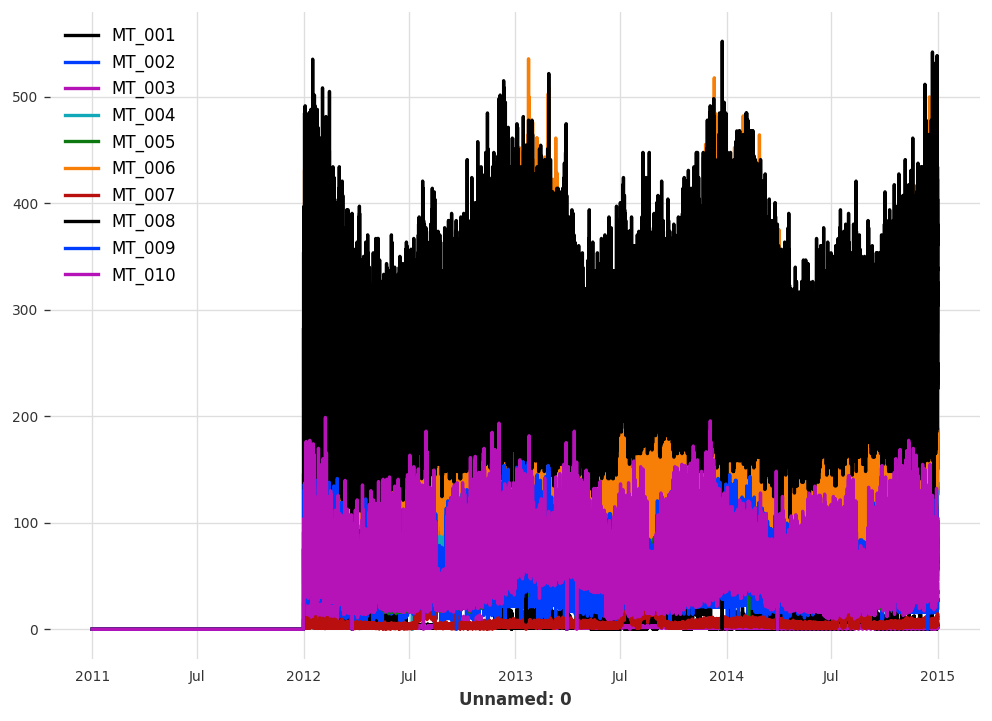

In [15]:
multi_serie_elec = ElectricityDataset().load()
multi_serie_elec.plot()

/Users/cngvng/anaconda3/envs/ai-dev/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


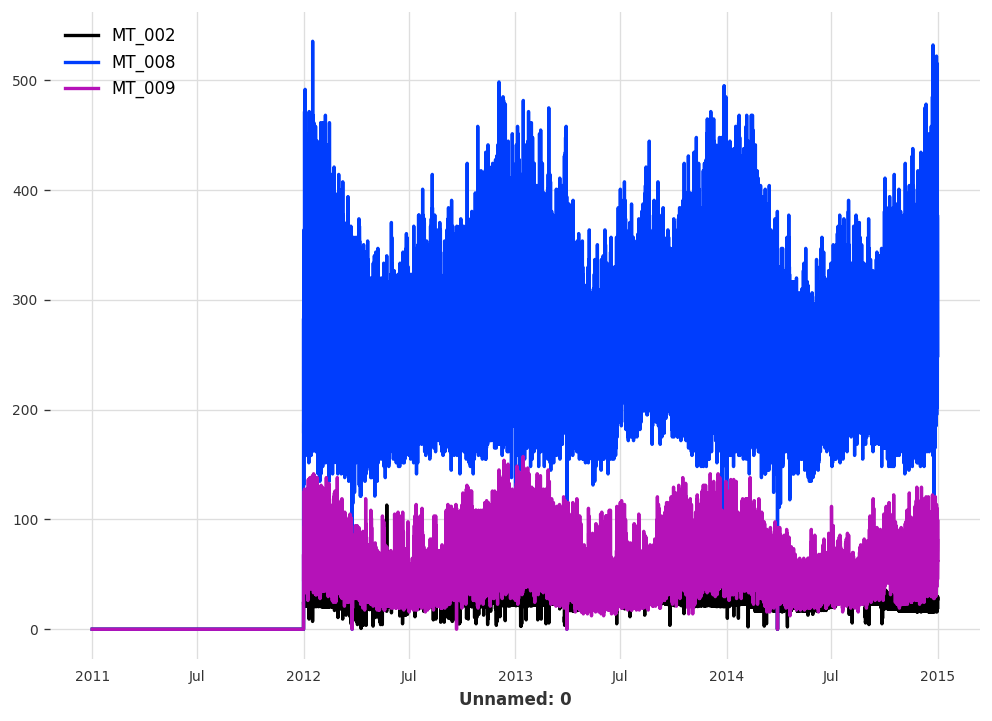

In [16]:
retained_components = ["MT_002", "MT_008", "MT_009"]
multi_serie_elec = multi_serie_elec[retained_components]
# resampling the multivariate time serie
multi_serie_elec = multi_serie_elec.resample(freq="1H")
multi_serie_elec.plot()
plt.show()

In [17]:
from darts.dataprocessing.transformers import Scaler

In [18]:
training_set, validation_set = multi_serie_elec[:-24], multi_serie_elec[-24:]

# define a scaler, by default, normalize each component between 0 and 1
scaler_dataset = Scaler()
# scaler is fit on training set only to avoid leakage
training_scaled = scaler_dataset.fit_transform(training_set)
validation_scaled = scaler_dataset.transform(validation_set)

In [26]:
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

/Users/cngvng/anaconda3/envs/ai-dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

In [28]:
from darts.metrics import mape, smape, mae

In [29]:
model_VARIMA = VARIMA(p=12, d=0, q=0, trend="n")

model_GRU = RNNModel(
    input_chunk_length=24,
    model="LSTM",
    hidden_dim=25,
    n_rnn_layers=3,
    training_length=36,
    n_epochs=20
)

# training and prediction with the VARIMA model
forecast_VARIMA = fit_and_pred(model_VARIMA, training_scaled, validation_scaled)
print("MAE (VARIMA) = {:.2f}".format(mae(validation_scaled, forecast_VARIMA)))

# training and prediction with the RNN model
forecast_RNN = fit_and_pred(model_GRU, training_scaled, validation_scaled)
print("MAE (RNN) = {:.2f}".format(mae(validation_scaled, forecast_RNN)))

## **Visualize the Time Series**

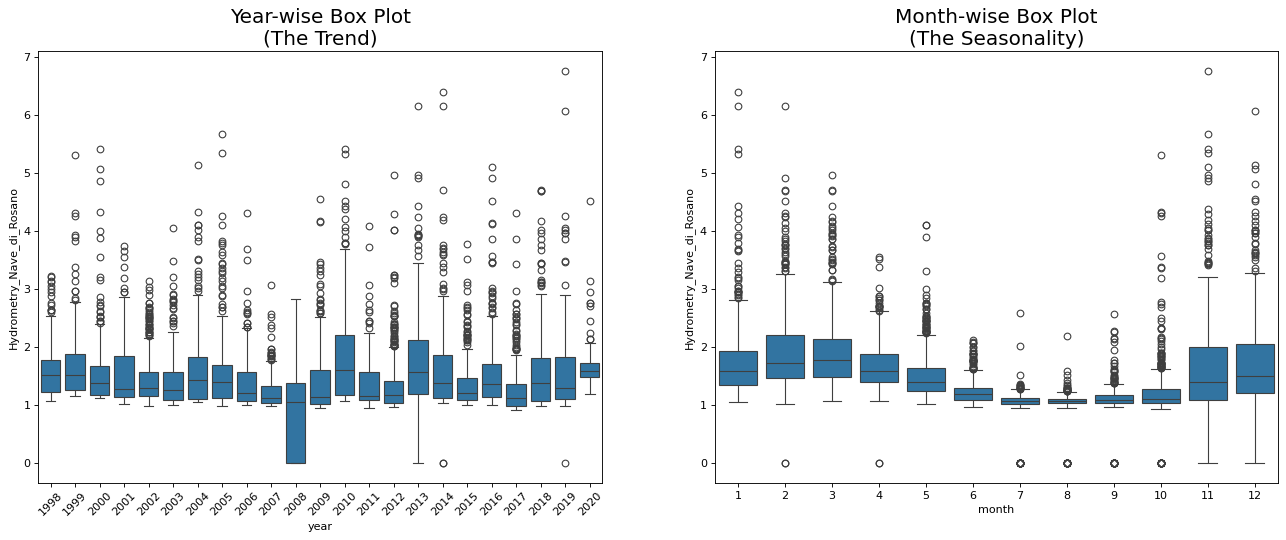

In [ ]:
forecast_VARIMA = scaler_dataset.inverse_transform(forecast_VARIMA)
forecast_RNN = scaler_dataset.inverse_transform(forecast_RNN)

labels = [f"forecast {component}" for component in retained_components]
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
validation_set.plot(ax=axs[0])
forecast_VARIMA.plot(label=labels, ax=axs[0])
axs[0].set_ylim(0, 500)
axs[0].set_title("VARIMA model forecast")
axs[0].legend(loc="upper left")
validation_set.plot(ax=axs[1])
forecast_RNN.plot(label=labels, ax=axs[1])
axs[1].set_ylim(0, 500)
axs[1].set_title("RNN model forecast")
axs[1].legend(loc="upper left")
plt.show()